In [1]:
# This script generates a 5-panel supplementary figure illustrating spatial-diffraction–induced
# phasor averaging in FLIM. It creates each panel as an independent matplotlib figure (no subplots),
# then assembles them into a single composite image using PIL. No seaborn is used.

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import io, os, math

# -----------------------------
# Helper: mono-exponential phasor
# -----------------------------
def phasor_mono(omega, tau):
    g = 1.0/(1.0+(omega*tau)**2)
    s = (omega*tau)/(1.0+(omega*tau)**2)
    return g, s

# -----------------------------
# Global parameters for the demo
# -----------------------------
# Modulation frequency ~80 MHz (rad/ns)
f_MHz = 80.0
omega = 2.0*np.pi*(f_MHz/1000.0)  # rad/ns since 1 ns^-1 = 1 GHz
tau_A = 1.0   # ns
tau_B = 4.0   # ns

gA, sA = phasor_mono(omega, tau_A)
gB, sB = phasor_mono(omega, tau_B)

# Weights for a boundary pixel (panel b/c example)
wA = 0.5
wB = 1.0 - wA
gM = wA*gA + wB*gB
sM = wA*sA + wB*sB

# -----------------------------
# Panel (a): Two domains + Gaussian PSF overlap schematic
# -----------------------------
def make_panel_a(path):
    W, H = 900, 600
    fig = plt.figure(figsize=(W/100, H/100), dpi=300)
    ax = plt.gca()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    # Domains: left (A) and right (B)
    ax.add_patch(plt.Rectangle((0,0), 0.5, 1.0, facecolor=(0.8,0.92,1.0), edgecolor='none'))
    ax.add_patch(plt.Rectangle((0.5,0), 0.5, 1.0, facecolor=(1.0,0.9,0.9), edgecolor='none'))
    # Boundary line
    ax.plot([0.5,0.5],[0,1], lw=2, color='k', alpha=0.3)
    # Gaussian PSF centered at boundary pixel r0
    x = np.linspace(0,1,300)
    y = np.linspace(0,1,300)
    X, Y = np.meshgrid(x,y)
    x0, y0 = 0.5, 0.5
    sigma = 0.10
    PSF = np.exp(-((X-x0)**2+(Y-y0)**2)/(2*sigma**2))
    PSF = PSF/PSF.max()
    ax.imshow(PSF, extent=(0,1,0,1), origin='lower', cmap='gray', alpha=0.45)
    # Labels
    ax.text(0.25, 0.9, "Domain A (τ_A = %.1f ns)"%tau_A, ha='center', va='center', fontsize=16)
    ax.text(0.75, 0.9, "Domain B (τ_B = %.1f ns)"%tau_B, ha='center', va='center', fontsize=16)
    ax.text(x0, y0-0.16, "PSF at pixel r₀", ha='center', fontsize=14)
    ax.scatter([x0],[y0], s=120, c='k')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("(a) Two spatial lifetime domains and the diffraction-limited PSF", fontsize=18, pad=12)
    fig.tight_layout()
    fig.savefig(path, dpi=300, bbox_inches='tight')
    plt.close(fig)

# -----------------------------
# Panel (b): Decays IA, IB, and mixed I_meas at boundary
# -----------------------------
def make_panel_b(path):
    fig = plt.figure(figsize=(9,5), dpi=300)
    ax = plt.gca()
    t = np.linspace(0, 12.5, 600)  # ns
    A_A, A_B = 1.0, 1.0
    I_A = A_A*np.exp(-t/tau_A)
    I_B = A_B*np.exp(-t/tau_B)
    I_meas = wA*I_A + wB*I_B
    ax.plot(t, I_A, lw=2, label="I_A(t) = A_A e^{-t/τ_A}")
    ax.plot(t, I_B, lw=2, label="I_B(t) = A_B e^{-t/τ_B}")
    ax.plot(t, I_meas, lw=3, linestyle='--', label="I_meas(t) = w_A I_A + w_B I_B")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Intensity (a.u.)")
    ax.set_title("(b) True local decays vs. PSF-weighted mixed decay at the interface", pad=10)
    ax.legend(loc='upper right', frameon=False)
    fig.tight_layout()
    fig.savefig(path, dpi=300, bbox_inches='tight')
    plt.close(fig)

# -----------------------------
# Panel (c): Phasor plot with semicircle, G_tauA, G_tauB, and G_meas on the line
# -----------------------------
def make_panel_c(path):
    fig = plt.figure(figsize=(7,7), dpi=300)
    ax = plt.gca()
    # Universal semicircle
    theta = np.linspace(0, np.pi, 400)
    semicircle_g = 0.5*(1+np.cos(theta))
    semicircle_s = 0.5*np.sin(theta)
    ax.plot(semicircle_g, semicircle_s, lw=2)
    # Points
    ax.scatter([gA],[sA], s=80)
    ax.scatter([gB],[sB], s=80)
    ax.scatter([gM],[sM], s=90, marker='D')
    # Connecting line
    ax.plot([gA,gB],[sA,sB], linestyle='--', lw=1.5)
    # Labels
    ax.text(gA, sA+0.03, "G(τ_A)", ha='center')
    ax.text(gB, sB+0.03, "G(τ_B)", ha='center')
    ax.text(gM, sM-0.05, "G_meas", ha='center')
    ax.set_xlabel("g (in-phase)")
    ax.set_ylabel("s (quadrature)")
    ax.set_title("(c) Phasor averaging: G_meas = w_A G(τ_A) + w_B G(τ_B)", pad=10)
    ax.set_xlim(0,1.02); ax.set_ylim(0,0.55)
    ax.set_aspect('equal')
    ax.grid(alpha=0.2)
    fig.tight_layout()
    fig.savefig(path, dpi=300, bbox_inches='tight')
    plt.close(fig)

# -----------------------------
# Panel (d): Apparent lifetime map across a 2D interface (smooth transition)
# -----------------------------
def make_panel_d(path):
    # Create a 2D field with a vertical interface at x=0
    W, H = 240, 160
    x = np.linspace(-1.2, 1.2, W)
    y = np.linspace(-0.8, 0.8, H)
    X, Y = np.meshgrid(x, y)
    # PSF is Gaussian; simulate apparent lifetime τ_app from phasor at each pixel by convolving contributions
    # For each pixel center (x0,y0), compute weights from left vs right half-planes via Gaussian PSF.
    sigma = 0.15
    def weight_left(x0):
        # Fractional integral of 1D Gaussian over x<0 centered at x0: wL = 0.5*(1 + erf( (-x0)/(sqrt(2)*sigma) ))
        return 0.5*(1.0 + math.erf((-x0)/(math.sqrt(2)*sigma)))
    # Compute phasor for each pixel using only x0 because interface is vertical and PSF separable
    g_app = np.zeros_like(X)
    s_app = np.zeros_like(X)
    for ix, x0 in enumerate(x):
        wL = weight_left(x0)
        wR = 1.0 - wL
        g_mix = wL*gA + wR*gB
        s_mix = wL*sA + wR*sB
        g_app[:, ix] = g_mix
        s_app[:, ix] = s_mix
    # Apparent lifetime via phase lifetime τ_phi = arctan(s/g)/ω
    tau_phi = np.arctan2(s_app, g_app)/omega  # ns
    # Plot heatmap
    fig = plt.figure(figsize=(8,4.6), dpi=300)
    ax = plt.gca()
    im = ax.imshow(tau_phi, extent=(x.min(), x.max(), y.min(), y.max()),
                   origin='lower', aspect='auto')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Apparent phase lifetime τ_phi (ns)")
    ax.set_title("(d) Apparent lifetime map across the A|B interface due to spatial averaging", pad=8)
    ax.set_xlabel("x (arb. units)")
    ax.set_ylabel("y (arb. units)")
    fig.tight_layout()
    fig.savefig(path, dpi=300, bbox_inches='tight')
    plt.close(fig)

# -----------------------------
# Panel (e): Effect of PSF size on G_meas at the boundary
# -----------------------------
def make_panel_e(path):
    fig = plt.figure(figsize=(7,7), dpi=300)
    ax = plt.gca()
    # Universal semicircle
    theta = np.linspace(0, np.pi, 400)
    semicircle_g = 0.5*(1+np.cos(theta))
    semicircle_s = 0.5*np.sin(theta)
    ax.plot(semicircle_g, semicircle_s, lw=2)
    # Two PSF widths -> different weights at the boundary pixel
    # When sigma is small, center pixel sees more local side; when large, it averages more equally.
    # Model with weights wA_small ~ 0.65, wA_large ~ 0.50 (boundary), illustrative.
    wA_small = 0.65
    wA_large = 0.50
    g_small = wA_small*gA + (1-wA_small)*gB
    s_small = wA_small*sA + (1-wA_small)*sB
    g_large = wA_large*gA + (1-wA_large)*gB
    s_large = wA_large*sA + (1-wA_large)*sB
    # Plot points and line
    ax.plot([gA,gB],[sA,sB], linestyle='--', lw=1.5)
    ax.scatter([gA],[sA], s=80)
    ax.scatter([gB],[sB], s=80)
    ax.scatter([g_small],[s_small], s=100, marker='o')
    ax.scatter([g_large],[s_large], s=100, marker='D')
    # Labels
    ax.text(gA, sA+0.03, "G(τ_A)", ha='center')
    ax.text(gB, sB+0.03, "G(τ_B)", ha='center')
    ax.text(g_small+0.02, s_small, "small PSF", ha='left', va='center')
    ax.text(g_large+0.02, s_large, "large PSF", ha='left', va='center')
    ax.set_xlabel("g (in-phase)")
    ax.set_ylabel("s (quadrature)")
    ax.set_title("(e) Changing PSF size shifts the measured phasor at interfaces", pad=10)
    ax.set_xlim(0,1.02); ax.set_ylim(0,0.55)
    ax.set_aspect('equal')
    ax.grid(alpha=0.2)
    fig.tight_layout()
    fig.savefig(path, dpi=300, bbox_inches='tight')
    plt.close(fig)

# -----------------------------
# Generate panels and composite
# -----------------------------
out_dir = "."
panel_paths = []
for name, maker in [
    ("panel_a.png", make_panel_a),
    ("panel_b.png", make_panel_b),
    ("panel_c.png", make_panel_c),
    ("panel_d.png", make_panel_d),
    ("panel_e.png", make_panel_e),
]:
    p = os.path.join(out_dir, name)
    maker(p)
    panel_paths.append(p)

# Assemble composite figure with PIL
imgs = [Image.open(p).convert("RGB") for p in panel_paths]

# Normalize widths to the maximum width among panels; maintain aspect
max_w = max(im.width for im in imgs)
resized = []
for im in imgs:
    if im.width != max_w:
        new_h = int(im.height * (max_w/im.width))
        # Pillow ≥ 10: use Image.Resampling.LANCZOS
        im = im.resize((max_w, new_h), Image.Resampling.LANCZOS)
    resized.append(im)

# Stack vertically with small gaps
gap = 18
total_h = sum(im.height for im in resized) + gap*(len(resized)-1)
composite = Image.new("RGB", (max_w, total_h), (255,255,255))

y = 0
labels = ['(a)','(b)','(c)','(d)','(e)']
draw = ImageDraw.Draw(composite)

for i, im in enumerate(resized):
    composite.paste(im, (0, y))
    # Panel label box
    draw.rectangle([8, y+8, 58, y+40], fill=(255,255,255))
    draw.text((12, y+12), labels[i], fill=(0,0,0))
    y += im.height + gap

composite_path = os.path.join(out_dir, "SupplementaryFigure_Phasor_SpatialDiffraction.png")
composite.save(composite_path, "PNG")

print("Saved:", composite_path)
for p in panel_paths:
    print("Saved:", p)


Saved: ./SupplementaryFigure_Phasor_SpatialDiffraction.png
Saved: ./panel_a.png
Saved: ./panel_b.png
Saved: ./panel_c.png
Saved: ./panel_d.png
Saved: ./panel_e.png


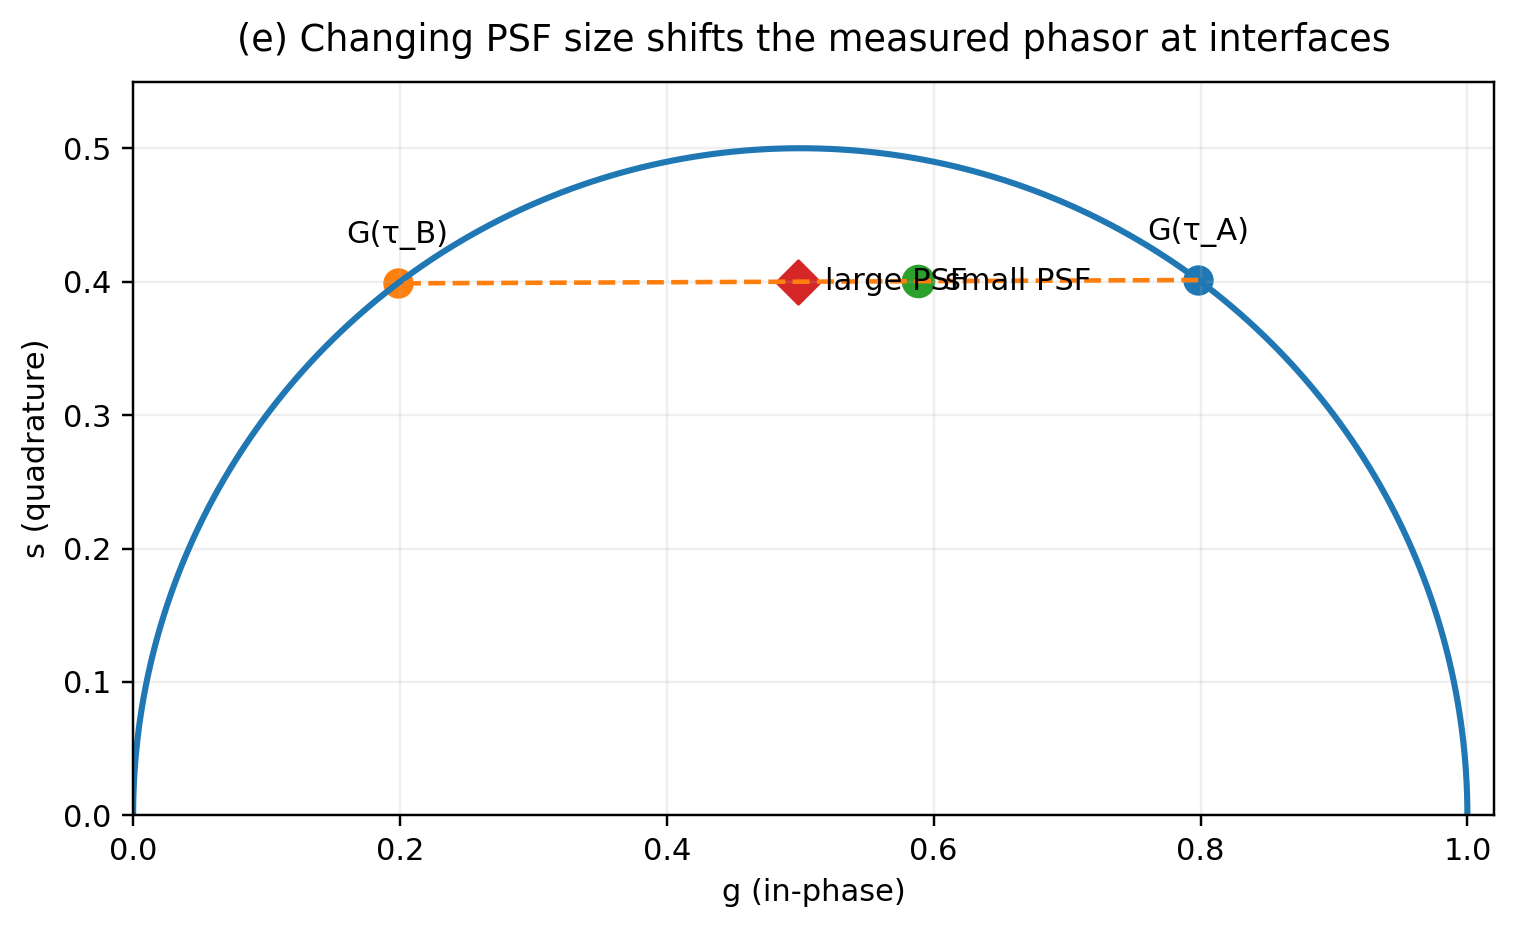

In [7]:
from IPython.display import Image

#Image(filename='./SupplementaryFigure_Phasor_SpatialDiffraction.png')
Image(filename='./panel_e.png')